## Prueba para obtener la imagen 

In [58]:
import sys
import os
import astropy.io.fits as pyfits
from astropy.table import Table
import numpy
import pylab
import itertools
from scipy import stats
from scipy import ndimage
import operator
import time
import datetime
import pickle
import IPython
from astropy.io import fits
from astropy.io import fits
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [59]:
darkss =[]
direc_dark=glob("/Volumes/Cami/TESIS/datos_obser_5_marzo/dark/*_c4.fits")

for archivo in tqdm(direc_dark):
    HR = fits.getheader(archivo)  #leer un archivo FITS
    #print(HR['EXPTIME'])
    #print(type(HR['EXPTIME']))
    if (HR['EXPTIME'] ==5.822):
        darkss.append(archivo)

100%|██████████| 604/604 [00:08<00:00, 70.93it/s]


In [85]:
size=250
master_dark = np.zeros((2048,2048))
for i in tqdm(range(0, 2050, size)):
    for j in range(0,2050,size):
        bloque = []       
        #if j%10== 0: print(i,j)
        for archivo in darkss:
            img = fits.getdata(archivo)
            if img.shape !=(2048,2048):
                raise ValueError(f'wrong img shape {img.shape}')
            bloque.append(img[i:(i+size),j:(j+size)])
        #print(np.array(bloque).shape)
        bloque= np.median(bloque, axis=0)    #np.nanmedia
        #print(bloque.shape,np.mean(bloque))
        master_dark[i:(i+size),j:(j+size)]=bloque
        #break
    

100%|██████████| 9/9 [01:08<00:00,  7.60s/it]


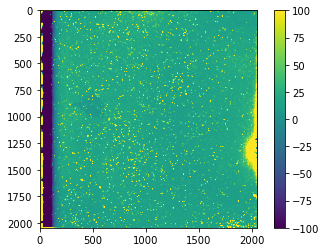

In [86]:
plt.imshow(master_dark,vmin=-100,vmax=100)
plt.colorbar()

Para crear una nueva imagen de master_dark

In [ ]:
Hdu = fits.PrimaryHDU(master_dark,HR)
Hdu.writeto('master_dark.fits')

## CORRECCIÓN POR DARKS

In [60]:
import sys
import os
import astropy.io.fits as pyfits
from astropy.table import Table
import numpy
import pylab
import itertools
from scipy import stats
from scipy import ndimage
import operator
import time
import datetime
import pickle
import IPython
from astropy.io import fits
from astropy.io import fits
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [226]:
Master_dark = fits.open("/Volumes/Cami/TESIS/datos_obser_5_marzo/dark/master_dark.fits")
Master_dark.info()
masterdark = Master_dark[0].data

header = fits.getheader("/Volumes/Cami/TESIS/datos_obser_5_marzo/dark/master_dark.fits")

Filename: /Volumes/Cami/TESIS/datos_obser_5_marzo/dark/master_dark.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     105   (2048, 2048)   float64   


In [62]:
direc_ciencia = str('/Volumes/Cami/TESIS/datos_obser_5_marzo/Imgs_ciencia')
os.chdir(direc_ciencia)
os.getcwd()

'/Volumes/Cami/TESIS/datos_obser_5_marzo/Imgs_ciencia'

La lista con todas las imágenes del cúmulo ACT-CL J0409.8-5624

In [63]:
direc_ciencia=glob("/Volumes/Cami/TESIS/datos_obser_5_marzo/Imgs_ciencia/*_c4.fits")
name_object=[]

for archivo in tqdm(direc_ciencia):
    hr = fits.getheader(archivo)  #leer un archivo FITS
    #print(HR['EXPTIME'])
    #print(type(HR['EXPTIME']))
    if (hr['OBJECT'] == 'ACT-CL J0409.8-5624'):
        name_object.append(archivo)

100%|██████████| 1558/1558 [00:21<00:00, 70.94it/s]


pasos para obtener el ScaleFactor

In [92]:
ciencia = []
archivo_fits=[]

for archivo in tqdm(name_object):
    archivo_fits = fits.open(archivo,"readonly",memmap=False) #leer un archivo FITS
    ciencia.append(archivo_fits)

exptime=[]
for i in range(len(ciencia)):
    exptime.append(ciencia[i]['PRIMARY'].header['EXPTIME'])
#exptime

100%|██████████| 135/135 [00:00<00:00, 355.05it/s]


La definición de scaleFactor es:
$$ scaleFactor = \frac{expTime}{darkExpTime}*sarkScaling[nfs]['slope'] + darkScaling[nfs]['intercept']$$

donde darkScaling[nfs]['slope'] = 1 y darkScaling[nfs]['intercept'] = 0 y el darkExpTime se busca en la imagen de masterdark(es constante el valor)

In [93]:
Exptime_dark=5.822

# calculando scaleFactor
for i in range(len(exptime)):
    exptime[i] /= 5.822
    
scaleFactor=np.array(exptime)
#type(scaleFactor)

### IMÁGENES DE CIENCIA CORREGIDAS POR DARKS

In [94]:
img_ciencia_correc = np.zeros((2048,2048))

for i in tqdm(range(len(name_object))):
    fits_ciencia = fits.open(name_object[i])
    img_ciencia = fits_ciencia['PRIMARY'].data
    
    img_ciencia_correc = img_ciencia - (masterdark*scaleFactor[i])
    
    #Guardando las imágenes nuevas
    HR = fits_ciencia['PRIMARY'].header
    Hdu = fits.PrimaryHDU(img_ciencia_correc,HR)
    Hdu.writeto(name_object[i].replace('.fits','_dark.fits'))

100%|██████████| 135/135 [01:05<00:00,  2.05it/s]


## REDUCCIÓN IMÁGENES FLATS

In [58]:
#flatss =[]
#direc_ciencia=glob("/Volumes/Cami/TESIS/datos_obser_5_marzo/Imgs_ciencia/*_c4.fits")

#for archivo in tqdm(direc_ciencia):
#    mm = fits.getheader(archivo)  #leer un archivo FITS
#    #print(mm['OBSTYPE'])
#    #print(type(HR['EXPTIME']))
#    if (mm['OBSTYPE'] == 'tflat'):
#        flatss.append(archivo)


100%|██████████| 1559/1559 [00:03<00:00, 434.01it/s]


In [100]:
flatsss=[]
for archivo in tqdm(direc_ciencia):
    archivo_fits = fits.open(archivo,"readonly",memmap=False) #leer un archivo FITS
    if (archivo_fits['PRIMARY'].header['OBSTYPE'] =='tflat'):
        img = fits.getdata(archivo)
        flatsss.append(img)
media = np.nanmean(flatsss,axis=0)

100%|██████████| 1558/1558 [00:24<00:00, 63.06it/s]


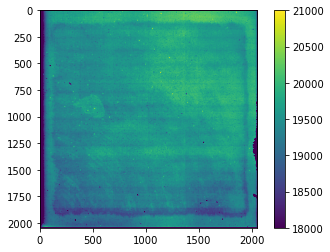

In [101]:
plt.imshow(media,vmin=18000,vmax=21000)
plt.colorbar()

In [103]:
PP=archivo_fits['PRIMARY'].header
PP['OBJECT']='master_flats'

In [105]:
hdu = fits.PrimaryHDU(media,PP)
#hdu.writeto('master_flats_dark.fits')

ERROR! Session/line number was not unique in database. History logging moved to new session 271


## CORRECCIÓN IMÁGENES CÚMULO POR FLATS


In [22]:
Direc_ciencia=glob("/Volumes/Cami/TESIS/datos_obser_5_marzo/Imgs_ciencia/*_dark.fits")
Master_flat = fits.open("/Volumes/Cami/TESIS/datos_obser_5_marzo/Imgs_ciencia/master_flats_dark.fits")
#Master_dark.info()
masterflat = Master_flat[0].data

ya que me dan valores 0 en el masterflat, se reemplaza  los ceros por el promedio de los píxeles vecinos.

In [113]:
n_x = n_y = 2048          #Tamaño de la imagen
for i in range(n_x):
    for j in range(n_y):
        if masterflat[i,j] == 0:
            masterflat[i,j] = masterflat[i-1:i+2,j-1:j+2].mean()
#(masterflat==0).sum()

In [114]:
img_ciencia_corr_flats = np.zeros((2048,2048))
mean_MF = masterflat.mean()
img_astro=[]

for i in tqdm(range(len(Direc_ciencia))):
    fits_ciencia_astro = fits.open(Direc_ciencia[i])
    img_ciencia = fits_ciencia_astro['PRIMARY'].data 
    
    if (fits_ciencia_astro['PRIMARY'].header['OBSTYPE']=='astro'):
        img=fits.getdata(Direc_ciencia[i])
        
        img_ciencia_corr_flats =(img/masterflat)*mean_MF
 
        #Guardando las imágenes nuevas
        Hdd = fits_ciencia_astro['PRIMARY'].header
        Hduu = fits.PrimaryHDU(img_ciencia_corr_flats,Hdd)
        Hduu.writeto(Direc_ciencia[i].replace('.fits','_flats.fits'))

100%|██████████| 137/137 [01:51<00:00,  1.23it/s]


## RESTA DEL CIELO

In [77]:
# DEFINO EL LUGAR DONDE SE ENCUENTRAN LAS IMÁGENES DE CIENCIA
direc_img_ciencia = glob("/Volumes/Cami/TESIS/datos_obser_5_marzo/Imgs_ciencia/*_dark_flats.fits")

In [78]:
filter_Ks = []
for archivo in tqdm(direc_img_ciencia):
    filter_1 = fits.getheader(archivo)  #leer un archivo FITS
    #print(HR['EXPTIME'])
    #print(type(HR['EXPTIME']))
    if (filter_1['FILTER'] == 'Ks'):
        filter_Ks.append(archivo)

100%|██████████| 135/135 [00:00<00:00, 474.67it/s]


In [79]:
loops=[]
for archivo in tqdm(filter_Ks):
    archivo_fits = fits.open(archivo,"readonly",memmap=False) #leer un archivo FITS
    if (archivo_fits['PRIMARY'].header['LOOP'] == 1):
        img = fits.getdata(archivo)
        loops.append(img)

100%|██████████| 107/107 [00:00<00:00, 415.88it/s]


In [80]:
# SACAMOS LA MEDIANA DE LAS IMÁGENES DE CIENCIA 
subtractSky = np.median(loops,axis=0)

In [88]:
img_ciencia_correc = np.zeros((2048,2048))

for i in tqdm(range(len(direc_img_ciencia))):
    img_sky = fits.open(direc_img_ciencia[i], "readonly",memmap = False)
    img_skyy = img_sky['PRIMARY'].data
    
    ## imágenes corregidas
    
    img_ciencia_correc = img - subtractSky[i]
        
    #Guardando las imágenes nuevas
   
    HR = img_sky['PRIMARY'].header
    Hdu = fits.PrimaryHDU(img_ciencia_correc,HR)
    Hdu.writeto(direc_img_ciencia[i].replace('.fits','_flats_sky.fits'))

  0%|          | 0/135 [00:00<?, ?it/s]


TypeError: unsupported operand type(s) for -: 'PrimaryHDU' and 'float'

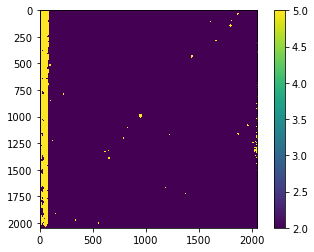

In [84]:
plt.imshow(img_ciencia_correc, vmin=2,vmax=5)
plt.colorbar()

In [147]:
archivo_fits = fits.open('/Volumes/Cami/TESIS/datos_obser_5_marzo/Imgs_ciencia/fsr_0040_01_c4_dark_flats_flats_sky.fits') # abre la imagen 
archivo_fits.info()                             #me entrega información de la imagen 
archivo_fits[0].header['Object']
header = fits.getdata("fsr_0028_02_c4_dark_flats_flats_sky.fits")
header

Filename: /Volumes/Cami/TESIS/datos_obser_5_marzo/Imgs_ciencia/fsr_0040_01_c4_dark_flats_flats_sky.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     105   (2048, 2048)   float64   


array([[ -989.16229116, -1481.64244664,   552.55183097, ...,
          740.70141265,   378.24618323,   505.19345619],
       [ -362.05788971, -1060.97567536,    75.87252463, ...,
          965.04992236,   852.31905106,   218.70139514],
       [ -301.22754479,   159.32348662,  -838.17516669, ...,
          778.74061649,   410.58395098,   693.72664524],
       ...,
       [-2046.7181359 ,    90.51142506,  -156.86438309, ...,
          787.90995662,   261.64559134,   196.1734816 ],
       [-1651.17539418, -1093.68895312,  -184.39795943, ...,
         1373.75589904,   759.84771766,   162.17956947],
       [ -982.54180744,    -2.10954335,  -240.20428264, ...,
         1217.92639337,   664.93141938,   287.29676705]])

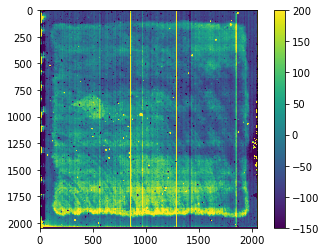

In [151]:
#fsr_0038_02
plt.imshow(header, vmin=-150,vmax=200)
plt.colorbar()

In [203]:
header2 = fits.getdata("fsr_0028_02_c4_dark.fits")

In [201]:
header = fits.getdata("fsr_0028_02_c4_dark_flats.fits")

In [202]:
header1= fits.getdata("fsr_0028_02_c4_dark_flats_flats_sky.fits")

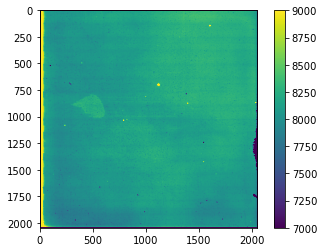

In [214]:
plt.imshow(header2,vmin=7000,vmax=9000)
plt.colorbar()

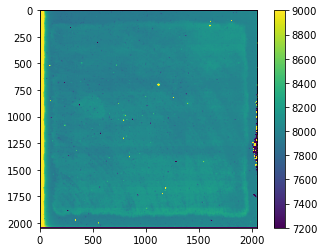

In [225]:
plt.imshow(header, vmin=7200,vmax=9000)
plt.colorbar()

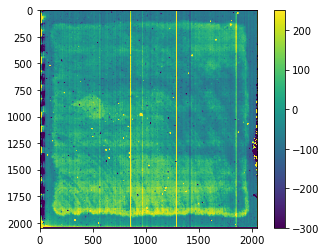

In [200]:
plt.imshow(header1, vmin=-300,vmax=250)
plt.colorbar()